In [13]:
# -*- coding: utf-8 -*-
import os
import math
import time
import random

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from scipy.optimize import minimize
from scipy.special import logsumexp
from datetime import datetime

import warnings

# This will ignore all warnings
# warnings.filterwarnings("ignore")

## Algorithm

![xx](figure/algorithms.png)

In [14]:
# set a seed so that the results are reproducible
def set_random_seeds(seed_value):

    np.random.seed(seed_value)
    random.seed(seed_value)

## Obstacle Design

In [15]:
class Obstacle:
    def __init__(self, obstacle_positions, obstacle_radius, boundary_x, boundary_y, obs_cost):
        self.obstacle_positions = obstacle_positions
        self.obstacle_radius = obstacle_radius
        self.obs_cost = obs_cost
        self.boundary_x = boundary_x
        self.boundary_y = boundary_y

    def compute_obstacle_cost(self, x_curr):
        num_obs = len(self.obstacle_positions)
        cost = 0
        for obs_i in range(num_obs):
            op = self.obstacle_positions[obs_i]
            cost += float(x_curr[0] > op[0] and x_curr[0] < op[0] + self.obstacle_radius[obs_i] and
                          x_curr[1] > op[1] and x_curr[1] < op[1] + self.obstacle_radius[obs_i]) * self.obs_cost
        return cost

    def compute_boundary_penalty(self, x_curr):
        return float(x_curr[0] < self.boundary_x[0] or x_curr[0] > self.boundary_x[1] or
                     x_curr[1] < self.boundary_y[0] or x_curr[1] > self.boundary_y[1]) * self.obs_cost

    def check_hit_obstacle(self, x_curr):
        for pos, r in zip(self.obstacle_positions, self.obstacle_radius):
            if (x_curr[0] > pos[0] and x_curr[0] < pos[0] + r and x_curr[1] > pos[1] and x_curr[1] < pos[1] + r):
                return True
        return False

    def check_hit_boundary(self, x_curr):
        return x_curr[0] < self.boundary_x[0] or x_curr[0] > self.boundary_x[1] or x_curr[1] < self.boundary_y[0] or x_curr[1] > self.boundary_y[1]
    
    def plot_obstacles(self, ax):
        for obs_pos, obs_r in zip(self.obstacle_positions, self.obstacle_radius):
            obs = plt.Rectangle(obs_pos, obs_r, obs_r, color='k', fill=True, zorder=6)
            ax.add_patch(obs)

class CircleObstacle(Obstacle):
    def __init__(self, obstacle_positions, obstacle_radius, boundary_x, boundary_y, obs_cost):
        super().__init__(obstacle_positions, obstacle_radius, boundary_x, boundary_y, obs_cost)

    def compute_obstacle_cost(self, x_curr):
        num_obs = len(self.obstacle_positions)
        cost = 0
        for obs_i in range(num_obs):
            op = self.obstacle_positions[obs_i]
            distance_to_center = np.sqrt((x_curr[0] - op[0])**2 + (x_curr[1] - op[1])**2)
            cost += float(distance_to_center <= self.obstacle_radius[obs_i]) * self.obs_cost
        return cost

    def plot_obstacles(self, ax):
        for obs_pos, obs_r in zip(self.obstacle_positions, self.obstacle_radius):
            obs = plt.Circle(obs_pos, obs_r, color='k', fill=True, zorder=6)
            ax.add_patch(obs)

class PolygonObstacle(Obstacle):
    def __init__(self, obstacle_positions, boundary_x, boundary_y, obs_cost):
        # Here, obstacle_positions should be a list of vertices for each polygon
        super().__init__(obstacle_positions, None, boundary_x, boundary_y, obs_cost)

    def compute_obstacle_cost(self, x_curr):
        num_obs = len(self.obstacle_positions)
        cost = 0
        for obs_i in range(num_obs):
            polygon = Polygon(self.obstacle_positions[obs_i])
            cost += float(polygon.contains_point(x_curr)) * self.obs_cost
        return cost

    def plot_obstacles(self, ax):
        for obs_pos in self.obstacle_positions:
            obs = Polygon(obs_pos, color='k', fill=True, zorder=6)
            ax.add_patch(obs)

class Map:
    def __init__(self, obstacles):
        self.obstacles = obstacles

    def compute_total_obstacle_cost(self, x_curr):
        total_cost = 0
        for obstacle in self.obstacles:
            total_cost += obstacle.compute_obstacle_cost(x_curr)
        return total_cost

    def compute_total_boundary_penalty(self, x_curr):
        total_penalty = 0
        for obstacle in self.obstacles:
            total_penalty += obstacle.compute_boundary_penalty(x_curr)
        return total_penalty

    def check_hit_any_obstacle(self, x_curr):
        for obstacle in self.obstacles:
            if obstacle.check_hit_obstacle(x_curr):
                return True
        return False

    def check_hit_any_boundary(self, x_curr):
        for obstacle in self.obstacles:
            if obstacle.check_hit_boundary(x_curr):
                return True
        return False

    def plot_map(self, ax):
        for obstacle in self.obstacles:
            obstacle.plot_obstacles(ax)


    



## Dynamics
We consider a continuous-time and continuous-space stochastic process $\bm x(t)\in\mathbb{R}^{n}$ satisfying a control affine dynamic system, as follows:  

$$\begin{equation}
    d\bm x(t) = f\left(\bm x(t),t\right)dt + \bm G\left(\bm x(t),t\right)
    \bm u(\bm x(t),t)dt +  \bm \Sigma(\bm x(t), t) d\bm \xi(t) .
\end{equation}$$

Here, $f\left(\bm x(t),t\right)\in \mathbb{R}^n$ is a nonlinear passive dynamic, $\bm u(\bm x(t),t)\in \mathbb{R}^{p}$ is a control input, a control transition matrix $\bm G(\bm x(t),t)\in\mathbb{R}^{n\times p}$ is a full rank matrix-valued function with $n\geq p$. In addition, $\bm \xi(t)\in\mathbb{R}^{k}$ is a diffusion process and $\Sigma(\bm x(t), t)\in\mathbb{R}^{n\times k}$ is a diffusion matrix that maps the noise to the state. We consider $\bm \xi(t)\in\mathbb{R}^{k}$ as a drifted diffusion process which is defined as $d\bm \xi(t) = \bm \mu\left(\bm x(t),t\right)dt + d\bm w(t)$.  $d\bm w(t)$ is the increment of a standard Wiener process and the drift term $\bm \mu(\bm x, t)\in\mathbb{R}^{k}$ is the deterministic component that influences the expected rate of change of the process. Hence, $\bm \mu(\bm x, t)$  can be interpreted as a systemic bias in the evolution of the stochastic process over time.

In [16]:
class Dynamics_Linearized:
    def __init__(self, F, G, S):
        self.F = F
        self.G = G
        self.S = S

    def compute_next_state(self, state, control, noise):
        return self.F @ state + self.G @ control + self.S @ noise

In [17]:
class Dynamics_Nonlinear:
    def __init__(self, dt):
        self.dt = dt

    def compute_next_state(self, state, control, noise):
        next_state = np.zeros_like(state)
        next_state[0] = state[0] + self.dt * (control[0] + noise[0]) * np.cos(state[2])
        next_state[1] = state[1] + self.dt * (control[0] + noise[0]) * np.sin(state[2])
        next_state[2] = state[2] + self.dt * (control[1] + noise[1])
        return next_state

## Sampling

In [18]:
def estimate_mu(true_mu, Sigma, num_trajs):
    return np.mean(np.random.multivariate_normal(true_mu, Sigma, num_trajs), axis=0)

def sample_noise(true_mu, Sigma, T=10.0, dt=0.5, num_trajs=500, n=2) :
    time_steps = int(T/dt)
    estimated_mu = estimate_mu(true_mu, Sigma, num_trajs)
    noise_samples = np.random.multivariate_normal(estimated_mu, Sigma , [num_trajs, time_steps])
    return noise_samples

## Rollout

In [19]:
def stage_cost(dist2, dist_weight = 10):
    return dist_weight*dist2

def term_cost(dist2, goal_reached):
    return (1 - float(goal_reached)) * dist2

def dist_to_goal_function(x_curr, x_goal):
    return np.linalg.norm(x_curr - x_goal)

def rollout(dynamics, environment, x_init, x_goal, u_curr, obs_pos, obs_r, T, dt, theta, noise_samples, dist_weight, Sigma, obs_cost=10, num_trajs=500, goal_tolerance=0.1):
    costs = np.zeros(num_trajs)
    # time_steps = len(u_curr) # Haven't defined u_curr yet
    time_steps = int(T//dt)
    goal_reached = False
    
    x_vis = np.zeros( (20, time_steps, 2) )*np.nan
    
    for k in range(num_trajs):
        #x_curr = np.zeros(n)
        #for i in range(n) :
        #    x_curr[i] = x_init[i]
        x_curr = x_init.copy()
        if k < 20 :
            x_vis[k, 0, :] = x_curr[:2]
            
        for t in range(time_steps):
            
            # Compute next state
            x_curr = dynamics.compute_next_state(x_curr, [0, 0], noise_samples[k, t, :])
            
            if k < 20:
                x_vis[k, t, :] = x_curr[:2]
                
            dist_to_goal = dist_to_goal_function(x_curr[:2], x_goal)
            
            # Calculate stage cost
            costs[k] += stage_cost(dist_to_goal, dist_weight)
            
            if dist_to_goal < 0.01 :
                break
            
            # Calculate obstacle cost
            costs[k] += environment.compute_total_obstacle_cost(x_curr)
                
            # Calculate boundary penalty
            costs[k] += environment.compute_total_boundary_penalty(x_curr)
                
            if dist_to_goal <= goal_tolerance:
                goal_reached = True
                break
            
            # Terminal cost
            costs[k] += term_cost(dist_to_goal, goal_reached) 
    return costs, x_vis

## Optimization

$$\hat{\lambda} \in \argmin \{\frac{\lambda}{\gamma} + \frac{1}{\lambda} \log (\frac{1}{M}\sum_{m=1}^M \exp(\lambda S^m))\}$$

$$\hat{u}_k \leftarrow \frac{\sum_{m=1}^M \exp(\hat{\lambda} S^m) w_k^m}{\sum_{m'=1}^M \exp(\hat{\lambda} S^{m'})}$$

In [20]:
# Objective Function

def opt_cost_func(lambda_, gamma, costs, num_trajs):
    return gamma / lambda_ - lambda_ * np.log(1/num_trajs * np.sum(np.exp(-costs / lambda_)))
    #return lambda_ / gamma  + 1 / lambda_ * np.log(1 / num_trajs * np.sum(np.exp(costs * lambda_)))
'''
def opt_cost_func(lambda_, gamma, costs, num_trajs):
    log_denominator = logsumexp(-costs / lambda_) - np.log(num_trajs)
    denominator = np.exp(log_denominator)
    if denominator == 0:
        return np.inf  # Return a large value to indicate failure
    return gamma / lambda_ - lambda_ * logsumexp(-costs / lambda_) - np.log(num_trajs)

def opt_cost_func(lambda_, gamma, costs, num_trajs):
    # Stabilize the exponential computation using logsumexp
    sum_exp = logsumexp(-costs / lambda_)
    
    # Compute the value inside the logarithm
    log_value = sum_exp - np.log(num_trajs)
    
    # If the value is too close to zero, return a large value
    if np.exp(log_value) < 1e-10:
        return np.inf
    
    return gamma / lambda_ - lambda_ * log_value
'''

'\ndef opt_cost_func(lambda_, gamma, costs, num_trajs):\n    log_denominator = logsumexp(-costs / lambda_) - np.log(num_trajs)\n    denominator = np.exp(log_denominator)\n    if denominator == 0:\n        return np.inf  # Return a large value to indicate failure\n    return gamma / lambda_ - lambda_ * logsumexp(-costs / lambda_) - np.log(num_trajs)\n\ndef opt_cost_func(lambda_, gamma, costs, num_trajs):\n    # Stabilize the exponential computation using logsumexp\n    sum_exp = logsumexp(-costs / lambda_)\n    \n    # Compute the value inside the logarithm\n    log_value = sum_exp - np.log(num_trajs)\n    \n    # If the value is too close to zero, return a large value\n    if np.exp(log_value) < 1e-10:\n        return np.inf\n    \n    return gamma / lambda_ - lambda_ * log_value\n'

In [21]:
def opt_cost_func(lambda_, gamma, costs, num_trajs):
    return gamma / lambda_ - lambda_ * np.log(1/num_trajs * np.sum(np.exp(-costs / lambda_)))
    
def calculate_new_control_sequence(costs, lambda_, noise_samples):
    costs = np.exp(-costs / lambda_)
    sum_costs = np.sum(costs)

    time_steps, n = noise_samples.shape[1:3]
    u_curr = np.zeros((time_steps, n))
    for k in range(len(costs)):
        u_curr[0, :] += (costs[k] / sum_costs) * noise_samples[k, 0, :]
    
    return u_curr


# Methods for updating the control sequence
def update_useq_risk_neutral(costs, u_curr, noise_samples, T, dt, lambda_neut=100, n=2) :
    return calculate_new_control_sequence(costs, lambda_neut, noise_samples)

def update_useq_bisection(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2) :    
    num_trajs = len(noise_samples)
    for gamma in gammas :
        lambda_l = 1e-3; lambda_r = 1e3
        # theta_l = -1e10; theta_r = 1e10 
        k = 0
        K = 300        
        while k < K :
            lambda_1 = lambda_l + (lambda_r - lambda_l) / 3
            lambda_2 = lambda_l + 2 * (lambda_r - lambda_l) / 3
            
            opt_cost_1 = opt_cost_func(lambda_1, gamma, costs, num_trajs)
            opt_cost_2 = opt_cost_func(lambda_2, gamma, costs, num_trajs)
            # print(- lambda_1 * np.log( 1/num_trajs * np.sum( np.exp( -costs / lambda_1)  ) ))
            
            if opt_cost_1 > opt_cost_2:
                lambda_l = lambda_1
            elif opt_cost_1 < opt_cost_2 :
                lambda_r = lambda_2
            
            if lambda_r - lambda_l <= 1e-3:
                break
            
            optimal_cost = min(opt_cost_1, opt_cost_2)
            k += 1
    
    return calculate_new_control_sequence(costs, lambda_r, noise_samples)

def update_useq_grid_search(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2) :
    num_trajs = len(noise_samples)
    lambda_grid = np.linspace(1e-3, 1e3, num_trajs)  # grid of lambda values
    for gamma in gammas :
        opt_costs = []
        for lambda_ in lambda_grid:
            opt_cost = opt_cost_func(lambda_, gamma, costs, num_trajs)
            opt_costs.append(opt_cost)
        lambda_r = lambda_grid[np.argmin(opt_costs)]  # Select the lambda that gives the minimum cost

        return calculate_new_control_sequence(costs, lambda_r, noise_samples)

def update_useq_NM(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2, desired_threshold=1e-3):
    num_trajs = len(noise_samples)
    lambda_r = 100  # Initialize lambda_r

    for gamma in gammas:
        best_result = None
        best_value = float('inf')  # Initialize to positive infinity for minimization
        best_method = None
        
        methods = ['Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP']
        
        for method in methods:
            try:
                result = minimize(opt_cost_func, x0=lambda_r, args=(gamma, costs, num_trajs), method=method)
                
                # Compare result.fun even if result.success is False
                if result.fun < best_value:
                    best_result = result
                    best_value = result.fun
                    best_method = method
            except ValueError as e:
                print(f"Error using method {method} for gamma = {gamma}: {e}")
        
        if best_result:  # If we found a result (regardless of success status)
            lambda_r = best_result.x[0]
            #print(f"For gamma = {gamma}, best method is {best_method} with value {best_value}.")
            
            # Stop the loop if the best_value is below the desired_threshold
            if best_value < desired_threshold:
                print(f"Desired threshold reached with value {best_value}. Stopping optimization.")
                break  # Break out of the gamma loop
        else:
            print("Optimization failed for gamma =", gamma)

    # Return the best lambda_r found
    return calculate_new_control_sequence(costs, lambda_r, noise_samples)




## Path Integral

In [22]:
def path_integral(dynamics, environment, true_mu, Sigma, x_init, x_goal, u_curr, dist_weight, obs_cost, obs_pos, obs_r, T, dt, theta, num_trajs, init_report, gammas, method):
    
    noise_samples = sample_noise(true_mu, Sigma, T, dt, num_trajs, n=2)
    costs, x_vis = rollout(dynamics, environment, x_init, x_goal, u_curr, obs_pos, obs_r, T, dt, theta, noise_samples, dist_weight, Sigma, obs_cost, num_trajs, goal_tolerance=0.1)   
    
    if method == 'DR Non':
        u_curr = update_useq_risk_neutral(costs, u_curr, noise_samples, T, dt, lambda_neut=100, n=2)
    elif method == 'DR bisection':
        u_curr = update_useq_bisection(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2)
    elif method == 'DR grid_search':
        u_curr = update_useq_grid_search(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2)
    elif method == 'DR NM':
        u_curr = update_useq_NM(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    return u_curr, x_vis


# Model parameters

In [23]:
## Obstacles design
obstacle_positions = np.array([[-2.5, 0.0], [0.0, -2.5]])
obstacle_radius = np.array([1.0, 1.0])

obs_cost = 1e3

boundary_x = [-4.0, 1.0]
boundary_y = [-1.0, 4.0]

obstacle = Obstacle(obstacle_positions = obstacle_positions, obstacle_radius = obstacle_radius, boundary_x = boundary_x, boundary_y = boundary_y, obs_cost = obs_cost)

circle_obstacle = CircleObstacle(obstacle_positions = np.array([[-2.5, 0.0], [0.0, -2.5]]), obstacle_radius = np.array([1.0, 1.0]), boundary_x = boundary_x, boundary_y = boundary_y, obs_cost = obs_cost)

# Create the obstacles
obstacle1 = Obstacle(obstacle_positions=np.array([[-2.5, 0.0]]), obstacle_radius=np.array([1.0]), 
                     boundary_x=boundary_x, boundary_y=boundary_y, obs_cost=obs_cost)

obstacle2 = Obstacle(obstacle_positions=np.array([[0.0, -2.5]]), obstacle_radius=np.array([1.0]), 
                     boundary_x=boundary_x, boundary_y=boundary_y, obs_cost=obs_cost)

# Create the map
environment = Map([obstacle1, obstacle2])

## Dynamics design
T = 10.0
dt = 0.1

F = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
        
G= np.array([[(dt**2)/2, 0],
             [0, (dt**2)/2],
             [dt, 0],
             [0, dt]])

dynamics = Dynamics_Linearized(F, G, G)

## Cost design

## Uncertainty design
#set_random_seeds(0)

true_mu = np.array([0.003, 0.003])
Sigma = np.array([[0.01, 0.0], 
                  [0.0, 0.01]])


method = 'DR Non' # method = 'DR Non', 'DR bisection', 'DR grid_search', 'DR NM'

n_data = 10
num_simulation = 10
max_steps = 600
num_trajs = 30

dist_weight = 0.01

gamma = [300]
# gamma = range(1, 1000, 10)

theta = 0.01
goal_tolerance = 0.1

x_init = np.array([-3.0, 3.0, 0, 0])
x_goal = np.array([0,0])
x_hists = np.zeros((num_simulation, max_steps+1, 2))*np.nan

success_time = []
success_index = []
fail_index = []

In [24]:
for k in range(num_simulation):
    
    terminate = False
    hit_obstacle = False
    hit_boundary = False

    # Simulation
    u_curr = np.zeros((int(T//dt), 2))
    x_hist = np.zeros((max_steps+1, 4)) * np.nan
    u_hist = np.zeros((max_steps+1, 2)) * np.nan
    x_hist[0] = x_init.copy()

    for t in range(max_steps):
        
        u_curr, x_vis = path_integral(dynamics, environment, true_mu, Sigma, x_hist[t], x_goal, u_curr, dist_weight, 
                            obs_cost, obstacle_positions, obstacle_radius, 
                            T, dt, theta, num_trajs, init_report=t, gammas=gamma, method=method) 
        u_hist[t] = u_curr[0]

        noise = true_mu + np.random.multivariate_normal(np.zeros(u_curr.shape[1]), Sigma) # drift term + increment of a standard Wiener process

        x_hist[t+1] = dynamics.compute_next_state(x_hist[t], u_curr[0], noise)

        hit_obstacle = environment.check_hit_any_obstacle(x_hist[t+1])
        if hit_obstacle:
            terminate = True
            fail_index.append(k)
            print("Hit obstacle")
            break
                
        hit_boundary = environment.check_hit_any_boundary(x_hist[t+1])
        if hit_boundary:
            terminate = True
            fail_index.append(k)
            print("Hit boundary")
            break
                
        # Goal check
        if  dist_to_goal_function(x_hist[t+1, :2], x_goal) <= goal_tolerance <= goal_tolerance:
            print(f"Goal reached at t={t * dt}s")
            success_time.append(t * dt)
            terminate = True
            success_index.append(k)
            break
    
    x_hists[k, :t, :] = x_hist[:t, :2]

    if terminate:
        fig, ax = plt.subplots()
        ax.plot([x_init[0]], [x_init[1]], '8', markersize=20, markerfacecolor='lime', label='Initial State', markeredgecolor='k', zorder=6)
        ax.plot([x_goal[0]], [x_goal[1]], '*', markersize=20, markerfacecolor='lime', label='Target State', markeredgecolor='k', zorder=6)
        environment.plot_map(ax)

        ax.plot(x_hist[:,0], x_hist[:,1], 'r', label='Past state')
        ax.set_xlim(boundary_x)
        ax.set_ylim(boundary_y)
        ax.set_xlabel(r'$p_{x}$')
        ax.set_ylabel(r'$p_{y}$')
        plt.gcf().set_dpi(600)
        ax.set_aspect('equal')
        plt.tight_layout()
        plt.show()

/var/folders/lf/cvhsltm529q5zyt6s5vt08l00000gn/T/ipykernel_63601/2721024362.py:11: RuntimeWarning: invalid value encountered in scalar divide
  u_curr[0, :] += (costs[k] / sum_costs) * noise_samples[k, 0, :]


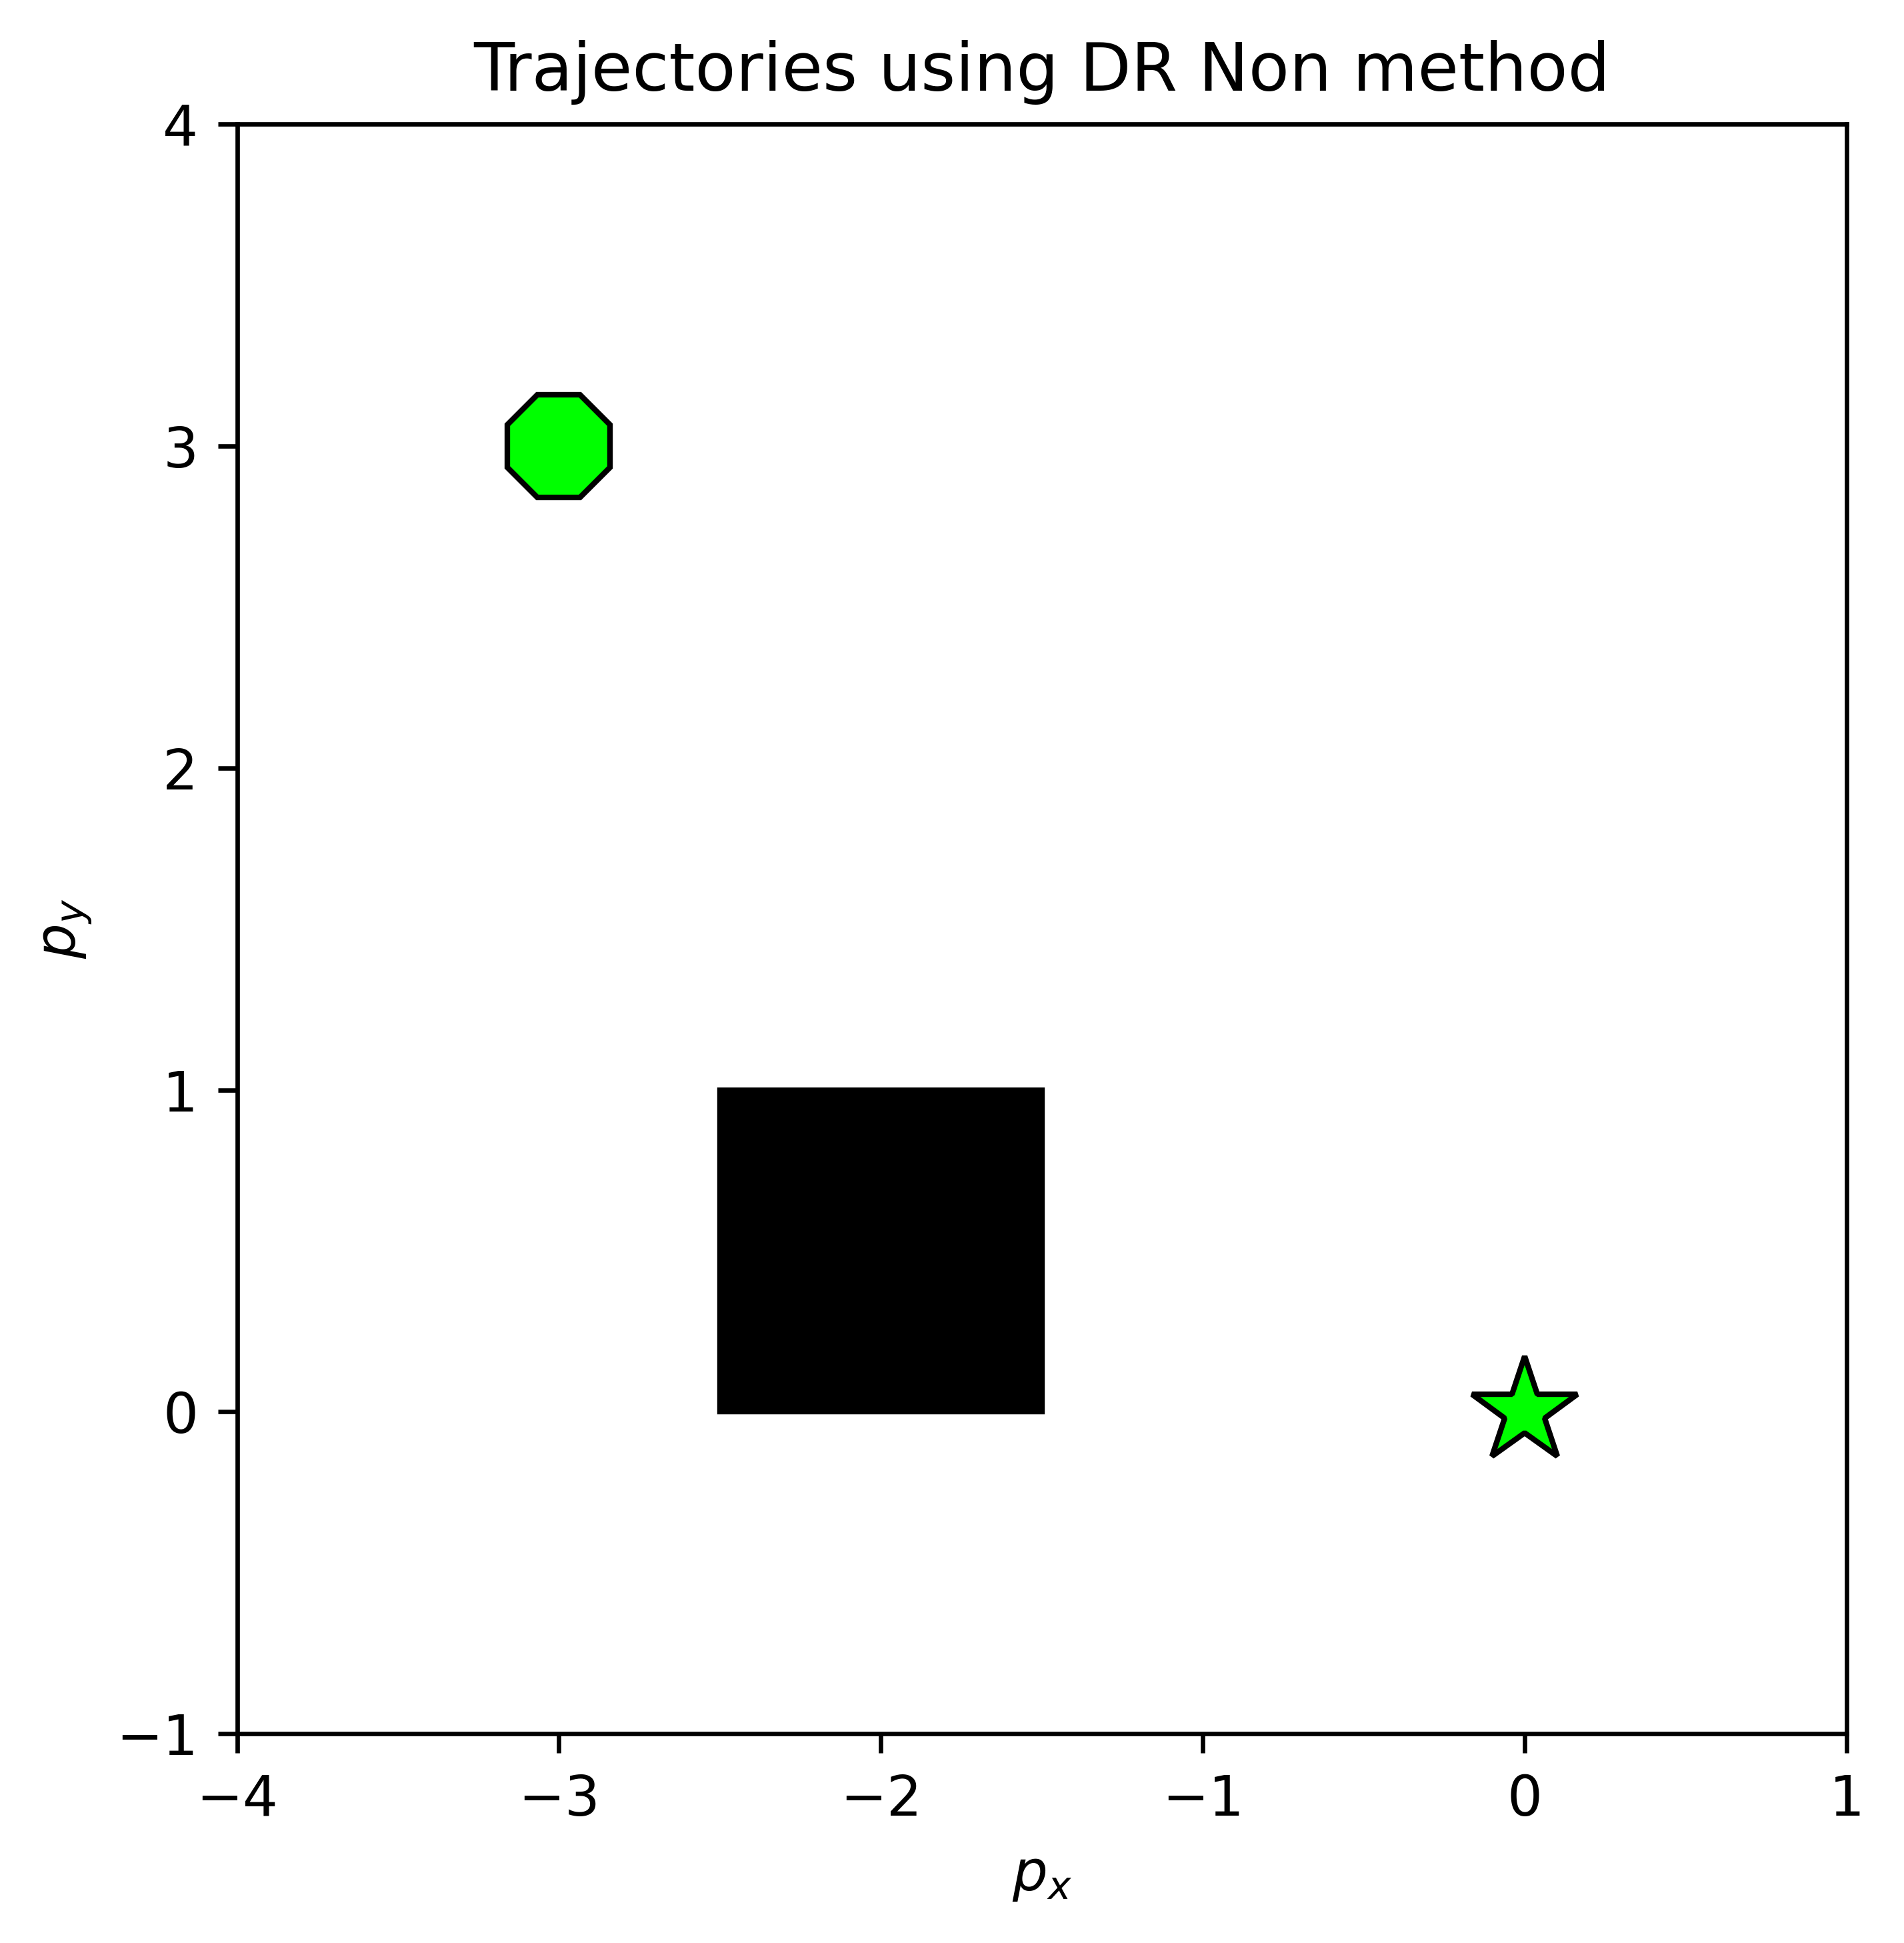

In [25]:
# Final Vis and Log Save

fig, ax = plt.subplots()
ax.plot([x_init[0]], [x_init[1]], '8', markersize=20, markerfacecolor='lime', label='Initial State', markeredgecolor='k', zorder=6)
ax.plot([x_goal[0]], [x_goal[1]], '*', markersize=20, markerfacecolor='lime', label='Target State', markeredgecolor='k', zorder=6)
environment.plot_map(ax)
#obstacle.plot_obstacles(ax)

ax.set_xlim(boundary_x)
ax.set_ylim(boundary_y)
ax.set_xlabel(r'$p_{x}$')
ax.set_ylabel(r'$p_{y}$')
plt.gcf().set_dpi(600)
ax.set_aspect('equal')
plt.tight_layout()

ax.plot(x_hists[success_index,:,0].T, x_hists[success_index,:,1].T, 'b', linewidth=0.8)
ax.plot(x_hists[fail_index,:,0].T, x_hists[fail_index,:,1].T, 'r', linewidth=0.8)
ax.set_title(f'Trajectories using {method} method')

# Save the plot with the current time as the filename
filename = os.path.join("./log", f"plot_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.png")
os.makedirs(os.path.dirname(filename), exist_ok=True)
fig.savefig(filename)

plt.show()
